In [62]:
import os 
import numpy as np 
import pandas as pd 
import glob
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import torch
from torch import nn
from torch.nn import functional as nnf
from torchvision.models import resnet18

In [15]:

# !git clone 'https://github.com/frompotenza/SidewalkSegmentation'

Cloning into 'SidewalkSegmentation'...
remote: Enumerating objects: 4910, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4910 (delta 0), reused 0 (delta 0), pack-reused 4906 (from 3)
Receiving objects: 100% (4910/4910), 1.75 GiB | 37.26 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Updating files: 100% (2824/2824), done.


In [16]:
path_images = '/kaggle/working/SidewalkSegmentation/Dataset'

In [28]:
org_image_list = []
for filename in glob.glob("/kaggle/working/SidewalkSegmentation/dataset_resized/*"): 
    if filename.lower().endswith(('.png', '.jpg')): 
        im=Image.open(filename)
        im=np.array(im)
        org_image_list.append(im)

In [48]:
target_size = (640, 640)
raw_image_list = []
for filename in glob.glob("/kaggle/working/SidewalkSegmentation/dataset_raw/*"): 
    if filename.lower().endswith(('.png', '.jpg')): 
        im=Image.open(filename)
        if im is not None:
            im = cv2.resize(np.array(im), target_size)
        im=np.array(im)
        raw_image_list.append(im)

In [18]:
seg_image_list = []
for filename in glob.glob("/kaggle/working/SidewalkSegmentation/segmented_images/*"): 
    if filename.lower().endswith(('.png', '.jpg')): 
        im=Image.open(filename)
        im=np.array(im)
        seg_image_list.append(im)

In [50]:
shp_arr = [raw_image_list[i].shape for i in range(len(raw_image_list))]

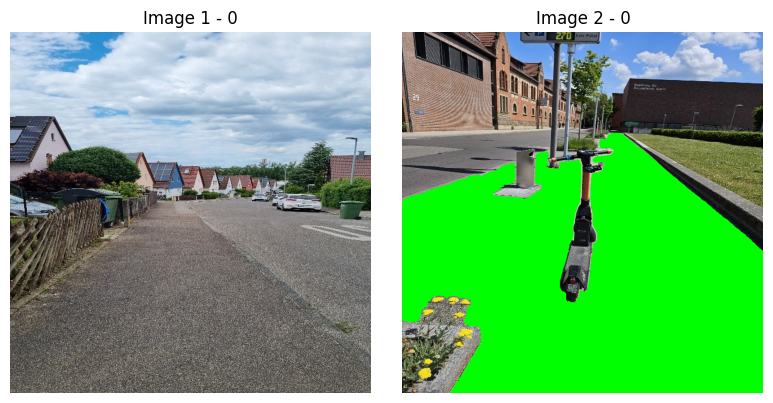

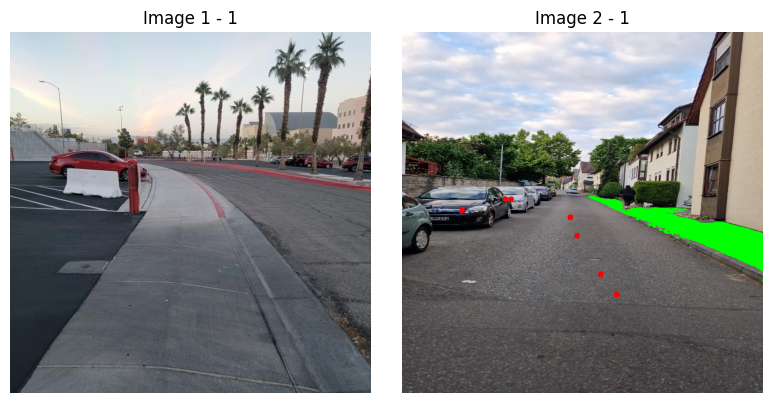

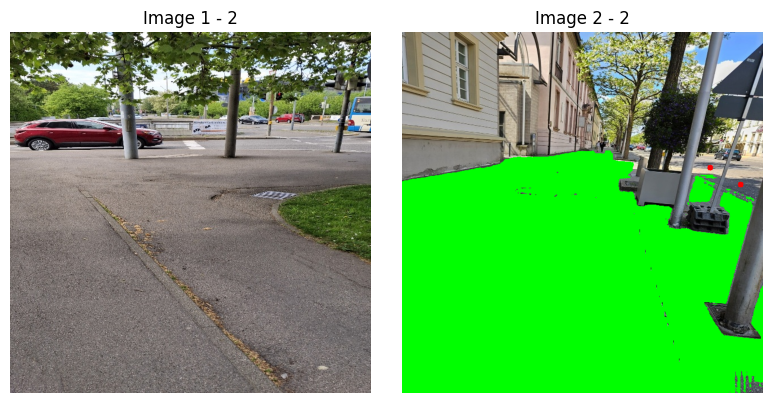

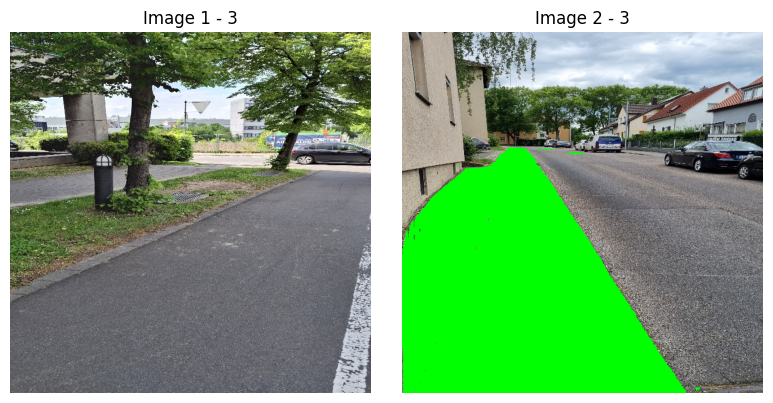

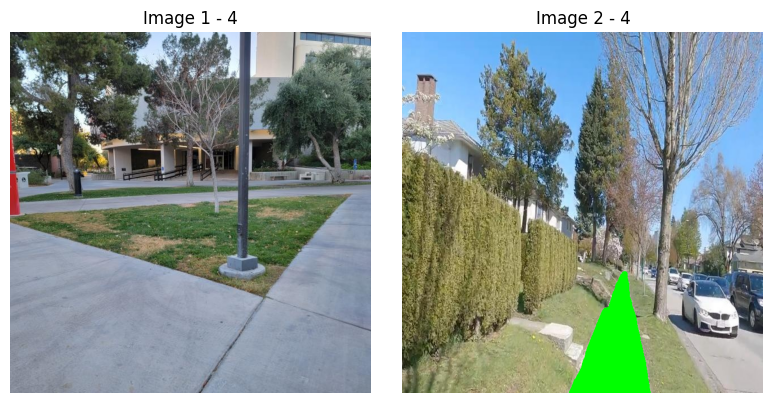

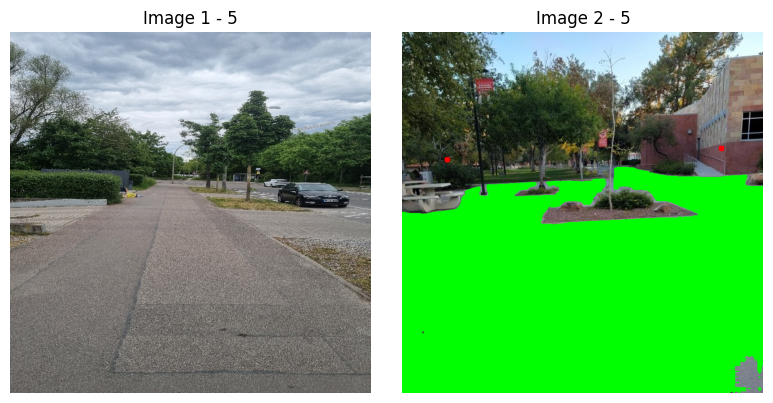

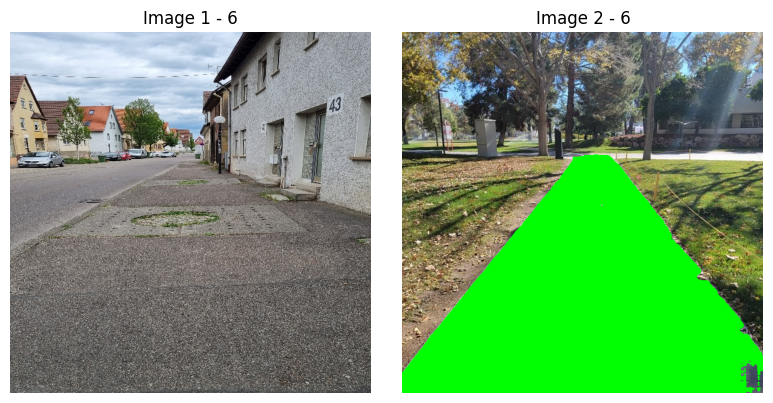

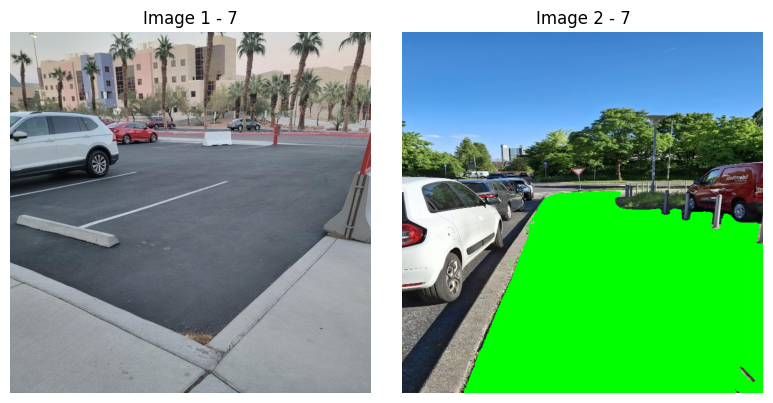

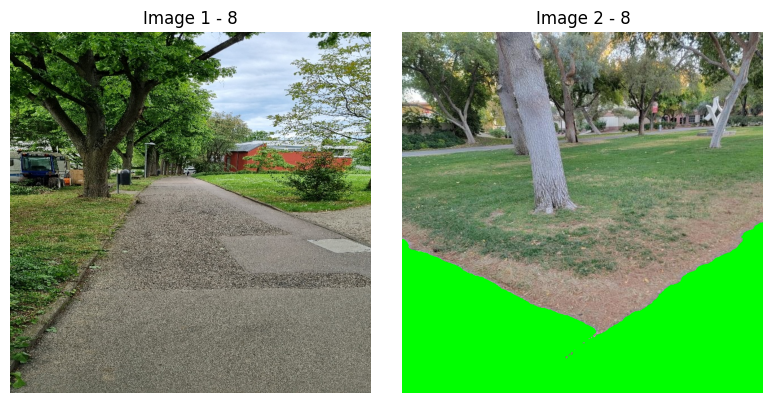

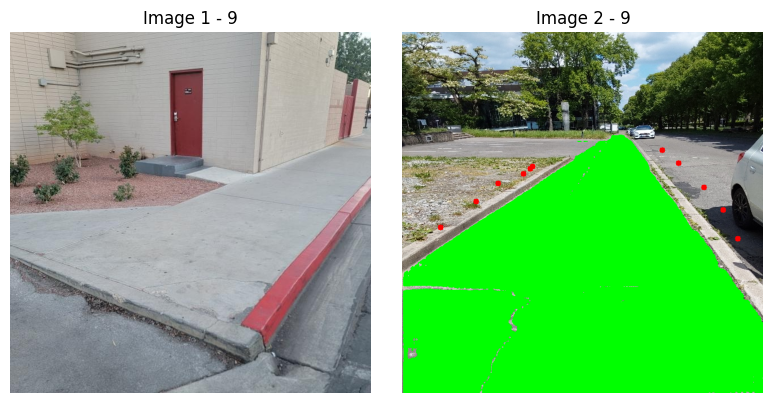

In [58]:
for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    ax1.imshow(org_image_list[i])
    ax1.set_title(f'Image 1 - {i}')
    ax1.axis('off')
    
    ax2.imshow(seg_image_list[i])
    ax2.set_title(f'Image 2 - {i}')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

In [63]:

class UBlock(nn.Module):
    def __init__(self, in_channels,posi="Left"):
        ####################
        super().__init__()
        in_channels=int(in_channels)
        if posi=="Left":
            if in_channels == 1 or in_channels == 2 or in_channels == 3:
                out_channels = 64 
            else:
                out_channels = int(2*in_channels)
            self.Block = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,(3,3),device=device,padding="same"),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,(3,3),device=device,padding="same"),
                nn.ReLU()
            )
        else:
            out_channels = int(in_channels//2)
            self.Block = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,(3,3),device=device,padding="same"),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,(3,3),device=device,padding="same"),
                nn.ReLU(),
                nn.ConvTranspose2d(out_channels,out_channels//2,(2,2),device=device,stride=2)
            )
            
            
            
            
    def forward(self, x):
        return self.Block(x)



class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.Pool=nn.MaxPool2d((2,2))
        
        self.Left = nn.Sequential(
            UBlock(in_channels)
        )
        out = 64
        for i in range(3):
            self.Left.append(UBlock(out))
            out*=2
        self.Bottom = nn.Sequential(
            UBlock(out),
            nn.ConvTranspose2d(int(out*2),int(out),(2,2),device=device,stride=2)
        )
            
            
        self.Right = nn.Sequential(
            UBlock(1024,"Right")
        )
        out = 512
        for i in range(2):
            self.Right.append(UBlock(out,"Right"))
            out//=2
            
            
        self.out=nn.Sequential(
            nn.Conv2d(out,out//2,(3,3),device=device,padding="same"),
            nn.ReLU(),
            nn.Conv2d(out//2,out//2,(3,3),device=device,padding="same"),
            nn.ReLU(),
            nn.Conv2d(out//2,out_channels,(1,1),device=device,padding="same")
        )
            
    def forward(self, x):
        left_values=[]
        while x.ndim > 4:
            x = x[0]
        for i in self.Left:
            left_values.append(i(x))
            x=i(x)
            x=self.Pool(x)
        x=self.Bottom(x)
        
        l=len(self.Right)
        for i in range(l):
            x=torch.cat((left_values[l-i],x),-3)
            x=self.Right[i](x)
        x=torch.cat((left_values[0],x),-3)
        return self.out(x)
        


In [88]:
first = org_image_list[0]
first = first[None, :]
print(first.shape)

for i in range(1, 10):
    first = np.concatenate((first, org_image_list[i][None, :]), axis=0)
    

(1, 640, 640, 3)


In [90]:
images = first

(10, 640, 640, 3)

In [97]:
seg_image_list[0].shape

(640, 640, 3)

In [66]:
device = "cpu"

SemNet  =UNet(3,1)
epo = 100

opt = torch.optim.Adam(SemNet.parameters(), lr=1e-4)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(opt,epo)
lossfunc = nn.BCEWithLogitsLoss()
#loss = 
losses = []
print(images.shape)
print(binary_masks.shape)
masks_tensor = torch.tensor(binary_masks).float().cuda()
images_tensor = torch.tensor(images).permute((0,3,1,2)).float()[:,None,:].cuda()
print(images_tensor.shape)
print(masks_tensor.shape)
#sem = np.where(orig>0,1,0)
start=time.time()
for i_epoch in range(epo):
    for i in range(10):
        pred = SemNet(images_tensor[i])
        opt.zero_grad()
        loss = lossfunc(pred.squeeze(), masks_tensor[i].squeeze())
            
        loss.backward()
        
        opt.step()
        
        losses += [float(loss)]
    scheduler.step()
    if (i_epoch+1)%20==0:  
        print("loss: "+str(np.mean(losses))+" epoch "+str(i_epoch+1))
    losses = []
print("Semantic Net DONE")
print(time.time()-start)


NameError: name 'images' is not defined